In [1]:
import pandas as pd

In [2]:
training_set_labels=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\training_set_labels.csv')
training_set_values=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\traning_set_values.csv') 

Train_data = pd.merge(training_set_values, training_set_labels, on='id')
df=Train_data.copy()

test_set_values = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\test_set_values.csv')


In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


# -----------------------------
# Columns to Drop
# -----------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# -----------------------------
# Raininess Mapping
# -----------------------------
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

# Global variables
categorical_cols = []
encoders = {}

# -----------------------------
# Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Building with PCA (No Output)
# -----------------------------
def build_model_for_PCA(train_df, data_proportion=1.0, n_estimators=250,
                       random_state=42, use_pca=False, n_components=None):

    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    scaler = None
    pca = None
    if use_pca:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    model.fit(X, y)

    return {
        'model': model,
        'scaler': scaler,
        'pca': pca
    }

# -----------------------------
# PCA Accuracy Benchmark Loop
# -----------------------------

#components_range = range(10, 34)

#graph

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def graph_builder(data_proportion=0.05, min=10, max=12):
    accuracies = []
    components_range = range(min, max)

    for n_components in components_range:
        # Build model with PCA
        rf_model = build_model_for_PCA(df, data_proportion=data_proportion, use_pca=True,
                                       n_components=n_components, n_estimators=250)
        
        # Prepare evaluation data
        df_cleaned = clean_encode(df.copy(), is_train=False)
        X_eval = df_cleaned.drop(columns=['status_group'])
        y_eval = df_cleaned['status_group']

        # Apply scaler and PCA
        X_eval = rf_model['scaler'].transform(X_eval)
        X_eval = rf_model['pca'].transform(X_eval)

        # Predict and calculate accuracy
        y_pred = rf_model['model'].predict(X_eval)
        accuracy = accuracy_score(y_eval, y_pred)
        accuracies.append(accuracy)


    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(components_range, accuracies, marker='o', linestyle='-', color='b')

    # Annotate each point with accuracy value
    for i, accuracy in enumerate(accuracies):
        plt.text(components_range[i], accuracy, f"{accuracy:.3f}", fontsize=9, ha='left', va='bottom')

    plt.title("Accuracy vs Number of PCA Components")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return accuracies



Accuracies for each number of components:
PCA Components: 10, Accuracy: 0.5535
PCA Components: 11, Accuracy: 0.5630
PCA Components: 12, Accuracy: 0.5627
PCA Components: 13, Accuracy: 0.5582
PCA Components: 14, Accuracy: 0.5638
PCA Components: 15, Accuracy: 0.5639
PCA Components: 16, Accuracy: 0.5653
PCA Components: 17, Accuracy: 0.5741
PCA Components: 18, Accuracy: 0.5687
PCA Components: 19, Accuracy: 0.5675
PCA Components: 20, Accuracy: 0.5670
PCA Components: 21, Accuracy: 0.5765
PCA Components: 22, Accuracy: 0.5669
PCA Components: 23, Accuracy: 0.5702
PCA Components: 24, Accuracy: 0.5725
PCA Components: 25, Accuracy: 0.5686
PCA Components: 26, Accuracy: 0.5748
PCA Components: 27, Accuracy: 0.5807
PCA Components: 28, Accuracy: 0.5755
PCA Components: 29, Accuracy: 0.5728
PCA Components: 30, Accuracy: 0.5805
PCA Components: 31, Accuracy: 0.5798


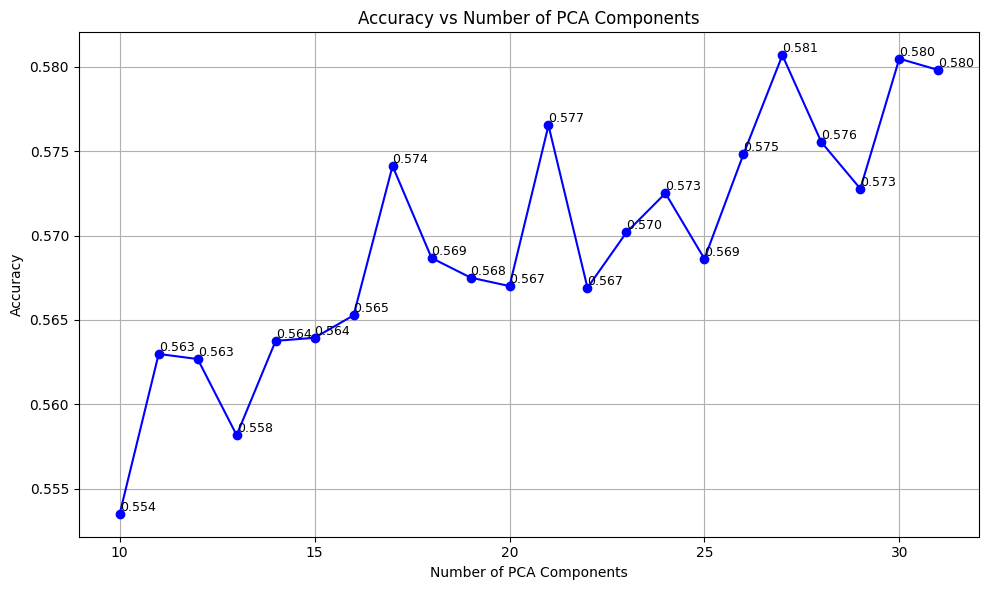

[0.5535016835016835,
 0.562979797979798,
 0.5626767676767677,
 0.5581649831649832,
 0.5637542087542088,
 0.563939393939394,
 0.5652693602693603,
 0.5741245791245791,
 0.5686700336700337,
 0.5675084175084175,
 0.567003367003367,
 0.5765319865319866,
 0.5669023569023569,
 0.5701851851851852,
 0.5725084175084175,
 0.5686195286195286,
 0.5748148148148148,
 0.5806902356902357,
 0.5755387205387206,
 0.5727777777777778,
 0.5804882154882155,
 0.5798148148148148]

In [ ]:
graph_builder(1,10,32) # first argument is data_proportion, second is min, third is max